# Exploratory Data Analysis

For the exploratory data analysis we explored the count of the overall column and the count of the verified column,  categorize the reviews, and found the most frequent words in the dataset.

### Load Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Start Spark Session

In [2]:
spark = SparkSession.builder.appName('eda').getOrCreate()

### Load Data

In [3]:
df = spark.read.json('Movies_and_TV.json.gz')

In [4]:
### Get Columns needed
df = df.select('overall', 'reviewText', 'verified')
df.show(5)

+-------+--------------------+--------+
|overall|          reviewText|verified|
+-------+--------------------+--------+
|    5.0|really happy they...|    true|
|    5.0|Having lived in W...|    true|
|    5.0|Excellent look in...|   false|
|    5.0|More than anythin...|    true|
|    4.0|This is a great m...|    true|
+-------+--------------------+--------+
only showing top 5 rows



In [5]:
### Number of null values by column 
print('Null reviewText:', df.where((df["reviewText"].isNull())).count())
print('Null overall:', df.where((df["overall"].isNull())).count())
print('Null verified:',df.where((df["verified"].isNull())).count())

Null reviewText: 8023
Null overall: 0
Null verified: 0


In [6]:
### Drop na values
df = df.na.drop()
df.count()

8757545

### Graphical Representation of overall column 

The graphical representation of the overall column shows that an overall of five is the largest value with four being the second biggest. The dataset looks to be imbalance as there are more positive ratings (4,5) compared to the negative ratings (1,2). 

In [7]:
### Get overall Count
o_count = df.groupBy("overall").count()
o_count.show()

+-------+-------+
|overall|  count|
+-------+-------+
|    1.0| 632857|
|    4.0|1496901|
|    3.0| 735630|
|    2.0| 406753|
|    5.0|5485404|
+-------+-------+



In [8]:
### Convert to pandas 
plot_df = o_count.toPandas()
plot_df.head()

,overall,count
0,1.0,632857
1,4.0,1496901
2,3.0,735630
3,2.0,406753
4,5.0,5485404


Text(0.5, 1.0, 'Overall Count')

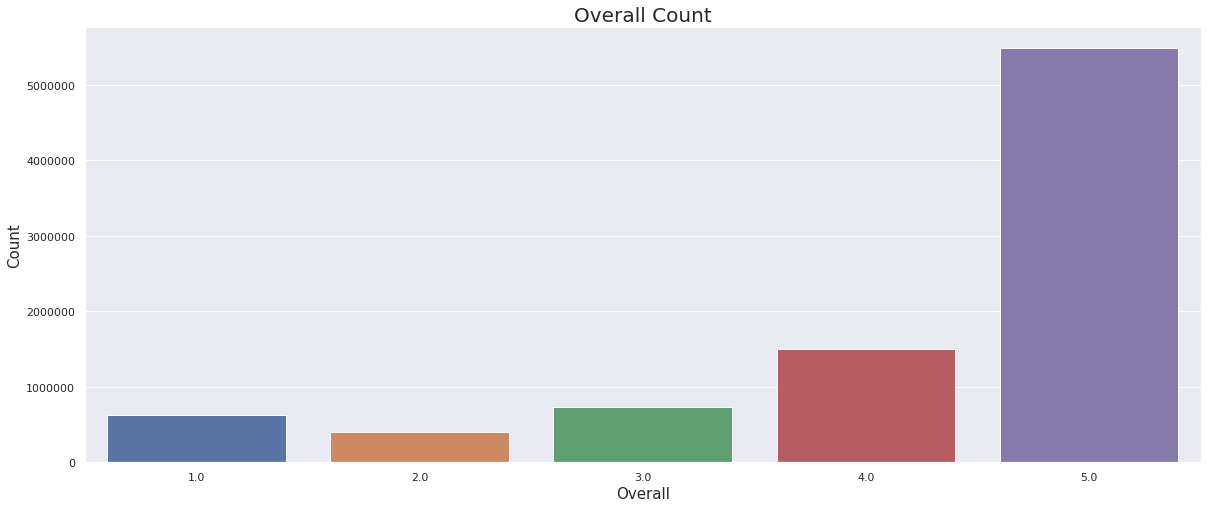

In [9]:
### plot 
sns.set()
plt.figure(figsize=(20,8))
sns.barplot(data = plot_df, x = 'overall', y = 'count')
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Overall',fontsize = 15)
plt.title('Overall Count',fontsize = 20)

### Graphical Representation of verified column 

The graphical representation of the verified column shows that there is about a 3 to 1 difference between true verified to false verified. 

In [10]:
### Get verified count
v_count = df.groupBy("verified").count()
v_count.show()

+--------+-------+
|verified|  count|
+--------+-------+
|    true|6723716|
|   false|2033829|
+--------+-------+



In [11]:
### Convert to pandas 
plot_df2 = v_count.toPandas()
plot_df2.head()

,verified,count
0,True,6723716
1,False,2033829


Text(0.5, 1.0, 'Verified Count')

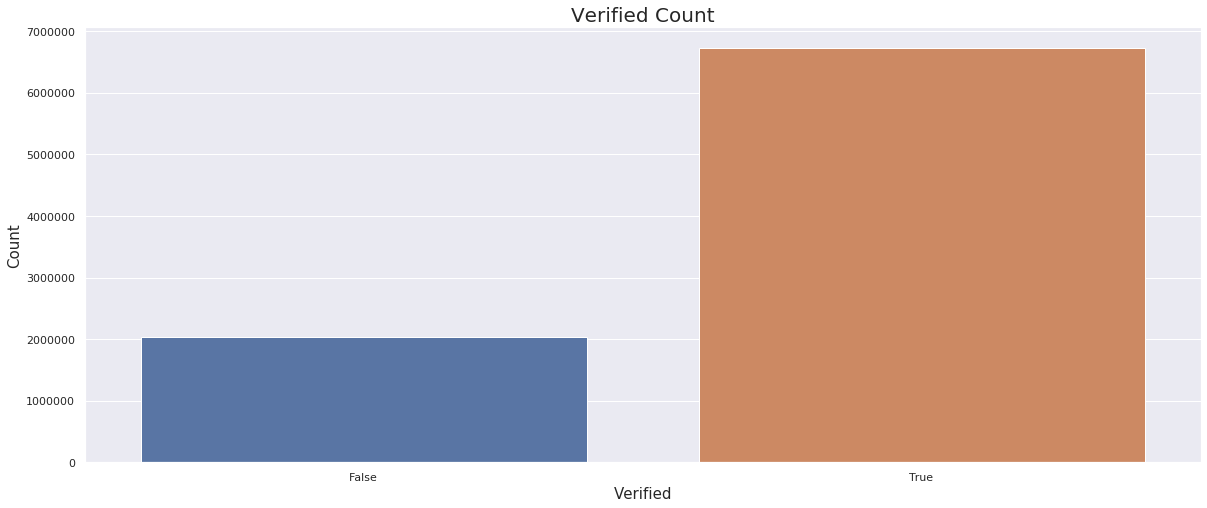

In [13]:
### plot 
sns.set()
plt.figure(figsize=(20,8))
sns.barplot(data = plot_df2, x = 'verified', y = 'count')
plt.ylabel('Count', fontsize = 15)
plt.xlabel('Verified',fontsize = 15)
plt.title('Verified Count',fontsize = 20)

### Categorize the length of reviews


When categorizing the reviews, we first cleaned the data to remove characters that don’t belong and remove extra spaces. The next step was to count the length of the review. Once done the mean was calculated for the length column. The mean was used to split the data into long and short reviews. Less than the mean was a short review  and greater than the mean was a long review. From the results we see that the dataset has more short reviews than long. 

In [14]:
### Function to clean text to get better count
def clean_text(c):
    c = lower(c)
    c = regexp_replace(c, "^rt ", "")
    c = regexp_replace(c, "[\=.]"," ")
    c = regexp_replace(c, "[^a-zA-Z0-9\\s]", "")
    c = regexp_replace(c, "  ", " ")
    c = regexp_replace(c, "   ", " ")
    return(c)

In [15]:
### Clean Review Text 
df = df.withColumn("clean_text", clean_text(df["reviewText"]))
df.show(5)

+-------+--------------------+--------+--------------------+
|overall|          reviewText|verified|          clean_text|
+-------+--------------------+--------+--------------------+
|    5.0|really happy they...|    true|really happy they...|
|    5.0|Having lived in W...|    true|having lived in w...|
|    5.0|Excellent look in...|   false|excellent look in...|
|    5.0|More than anythin...|    true|more than anythin...|
|    4.0|This is a great m...|    true|this is a great m...|
+-------+--------------------+--------+--------------------+
only showing top 5 rows



In [16]:
### Create Length Column 
df = df.withColumn("Length", size(split(df['clean_text'], ' ')))
df.show()

+-------+--------------------+--------+--------------------+------+
|overall|          reviewText|verified|          clean_text|Length|
+-------+--------------------+--------+--------------------+------+
|    5.0|really happy they...|    true|really happy they...|    32|
|    5.0|Having lived in W...|    true|having lived in w...|    42|
|    5.0|Excellent look in...|   false|excellent look in...|    29|
|    5.0|More than anythin...|    true|more than anythin...|    35|
|    4.0|This is a great m...|    true|this is a great m...|    32|
|    5.0|This movie was in...|    true|this movie was in...|    25|
|    5.0|This is a fascina...|    true|this is a fascina...|    42|
|    1.0|This DVD appears ...|    true|this dvd appears ...|    30|
|    1.0|This movie is not...|    true|this movie is not...|    35|
|    5.0|So sorry I didn't...|    true|so sorry i didnt ...|    64|
|    5.0|Product received ...|    true|product received ...|    50|
|    5.0|Believe me when I...|    true|believe m

In [17]:
### Mean of Length column
df.select(mean('Length')).show()

+-----------------+
|      avg(Length)|
+-----------------+
|58.60791020771232|
+-----------------+



In [18]:
### Categorize the length of reviews
df = df.withColumn("Type", when(df.Length > 58.60791020771232, "Long").otherwise("Short"))
df.show()

+-------+--------------------+--------+--------------------+------+-----+
|overall|          reviewText|verified|          clean_text|Length| Type|
+-------+--------------------+--------+--------------------+------+-----+
|    5.0|really happy they...|    true|really happy they...|    32|Short|
|    5.0|Having lived in W...|    true|having lived in w...|    42|Short|
|    5.0|Excellent look in...|   false|excellent look in...|    29|Short|
|    5.0|More than anythin...|    true|more than anythin...|    35|Short|
|    4.0|This is a great m...|    true|this is a great m...|    32|Short|
|    5.0|This movie was in...|    true|this movie was in...|    25|Short|
|    5.0|This is a fascina...|    true|this is a fascina...|    42|Short|
|    1.0|This DVD appears ...|    true|this dvd appears ...|    30|Short|
|    1.0|This movie is not...|    true|this movie is not...|    35|Short|
|    5.0|So sorry I didn't...|    true|so sorry i didnt ...|    64| Long|
|    5.0|Product received ...|    true

In [19]:
### Count of Type
df.groupBy('Type').count().show()

+-----+-------+
| Type|  count|
+-----+-------+
| Long|2068960|
|Short|6688585|
+-----+-------+



### Get the count of most common words

To get the count of the most common words in the dataset we first removed stop words and words that had a length less than 4. This was done to show words in the count that could be useful in our analysis. Once the data was clean we split the data so that each word in a review was its own row. The next step was to count how many times the word was used. We took the top 20 words to analyze. When viewing the top 20 words we saw that the top word was movie, which makes sense because the dataset is about movies and TV. 

In [20]:
#### remove numbers from text
df = df.withColumn("clean_text",regexp_replace(col('clean_text'), '\d+', ''))
df.show()

+-------+--------------------+--------+--------------------+------+-----+
|overall|          reviewText|verified|          clean_text|Length| Type|
+-------+--------------------+--------+--------------------+------+-----+
|    5.0|really happy they...|    true|really happy they...|    32|Short|
|    5.0|Having lived in W...|    true|having lived in w...|    42|Short|
|    5.0|Excellent look in...|   false|excellent look in...|    29|Short|
|    5.0|More than anythin...|    true|more than anythin...|    35|Short|
|    4.0|This is a great m...|    true|this is a great m...|    32|Short|
|    5.0|This movie was in...|    true|this movie was in...|    25|Short|
|    5.0|This is a fascina...|    true|this is a fascina...|    42|Short|
|    1.0|This DVD appears ...|    true|this dvd appears ...|    30|Short|
|    1.0|This movie is not...|    true|this movie is not...|    35|Short|
|    5.0|So sorry I didn't...|    true|so sorry i didnt ...|    64| Long|
|    5.0|Product received ...|    true

In [21]:
##### tokenize text 
tokenizer = Tokenizer(inputCol='clean_text', outputCol='words_token')
df_words = tokenizer.transform(df).select('words_token')
df_words.show(5)

+--------------------+
|         words_token|
+--------------------+
|[really, happy, t...|
|[having, lived, i...|
|[excellent, look,...|
|[more, than, anyt...|
|[this, is, a, gre...|
+--------------------+
only showing top 5 rows



In [22]:
##### Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words = remover.transform(df_words).select('words_clean')
df_words.show(5)

+--------------------+
|         words_clean|
+--------------------+
|[really, happy, g...|
|[lived, west, new...|
|[excellent, look,...|
|[anything, ive, c...|
|[great, movie, mi...|
+--------------------+
only showing top 5 rows



In [23]:
### remove short words 
filter_length_udf = udf(lambda row: " ".join([x for x in row if len(x) >= 4]))
df_words = df_words.withColumn('words', filter_length_udf(col('words_clean'))).select('words')
df_words.show(10)

+--------------------+
|               words|
+--------------------+
|really happy evan...|
|lived west guinea...|
|excellent look co...|
|anything challeng...|
|great movie missi...|
|movie english gre...|
|fascinating true ...|
|appears german en...|
|movie english alt...|
|sorry didnt purch...|
+--------------------+
only showing top 10 rows



In [24]:
#### dataframe of all words 
df2 = (df_words.select(explode(split(df_words.words, ' ')).alias('word')))
df2 = df2.where(df2.word != '')
df2.show(20)

+-----------+
|       word|
+-----------+
|     really|
|      happy|
|evangelised|
|    spoiler|
|      alert|
|      happy|
|     ending|
|      liked|
|      since|
|    started|
|  worrisome|
|       yeah|
|      great|
|    stories|
| missionary|
|     movies|
|     really|
|      short|
|       half|
|       hour|
+-----------+
only showing top 20 rows



In [25]:
#### Top 20 words
df2.groupby('word').count().orderBy('count',ascending = False).show(20)

+------+-------+
|  word|  count|
+------+-------+
| movie|4677481|
| great|2434048|
|  good|2135220|
|  film|1972439|
|  like|1715628|
|  love|1471621|
| story|1259479|
|  time|1206601|
|really|1124064|
| watch|1073072|
|  well|1057550|
|  show| 975261|
|series| 961480|
|  much| 905314|
|movies| 905118|
| first| 886379|
|  even| 818667|
|  best| 783046|
|  also| 747537|
|  dont| 716623|
+------+-------+
only showing top 20 rows

